# Setup

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [183]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
pd.set_option('display.max_rows', 10)
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.transforms as mtransforms
plt.rcParams['figure.figsize'] = [16, 5]
pal = plt.get_cmap('Paired').colors

import quandl

In [3]:
from utils import *

In [4]:
tickers, prices = get_quandl_sharadar()

In [5]:
prices

,,Open,High,Low,Close,Volume,Dividends,Closeunadj,Lastupdated
Ticker,Date,,,,,,,,
AAPL,1998-12-31,1.446,1.478,1.411,1.462,67922400.0,0.00,40.94,2018-06-19
AXP,1998-12-31,34.967,35.100,34.100,34.167,2528700.0,0.00,102.50,2018-02-11
BA,1998-12-31,31.750,33.130,31.630,32.630,7343500.0,0.00,32.63,2018-02-11
CAT,1998-12-31,23.000,23.940,23.000,23.000,4147400.0,0.00,46.00,2018-02-11
CSCO,1998-12-31,23.220,23.500,22.953,23.250,29021600.0,0.00,93.00,2018-02-11
...,...,...,...,...,...,...,...,...,...
UNH,2018-07-09,252.130,254.010,251.050,253.670,2017318.0,0.00,253.67,2018-07-09
UTX,2018-07-09,126.010,126.990,125.810,126.680,3291148.0,0.00,126.68,2018-07-09
VZ,2018-07-09,51.030,51.110,50.680,50.740,10438936.0,0.59,50.74,2018-07-09


# Finding the trend in a single price

See An introduction to smoothing time series in python, [part 1](http://www.nehalemlabs.net/prototype/blog/2013/04/05/an-introduction-to-smoothing-time-series-in-python-part-i-filtering-theory/) and [part 2](http://www.nehalemlabs.net/prototype/blog/2013/04/09/an-introduction-to-smoothing-time-series-in-python-part-ii-wiener-filter-and-smoothing-splines/).

4911 days.


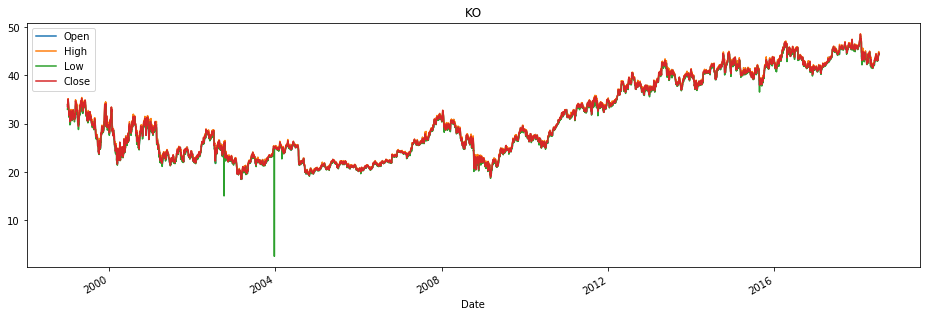

In [129]:
ticker = np.random.choice(tickers)
price = prices.loc[ticker]
print(len(price), 'days.')
price[['Open', 'High', 'Low', 'Close']].plot()
plt.title(ticker);

## Filters

In [130]:
from scipy.interpolate import UnivariateSpline
from scipy.signal import wiener, filtfilt, butter, gaussian, freqz
from scipy.ndimage import filters
import scipy.optimize as op

### Linear 

In [131]:
N = 40
f_sma = np.ones(N) / N

### Gaussian

In [132]:
f_ga = gaussian(N, N/3)
f_ga = f_ga / f_ga.sum()

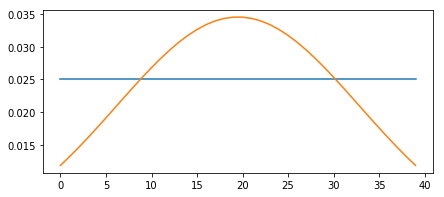

In [133]:
plt.figure(figsize=(7, 3))
plt.plot(f_sma, label='f_sma')
plt.plot(f_ga, label='f_ga')
plt.show()

### Wiener 

In [134]:
sigma = np.std(price.Close)
f_wi = lambda x: wiener(x, mysize=N, noise=sigma)

### Spline

In [135]:
f_sp = lambda x: UnivariateSpline(np.arange(len(x)), x)(np.arange(len(x)))

### Results

<Figure size 1152x432 with 0 Axes>

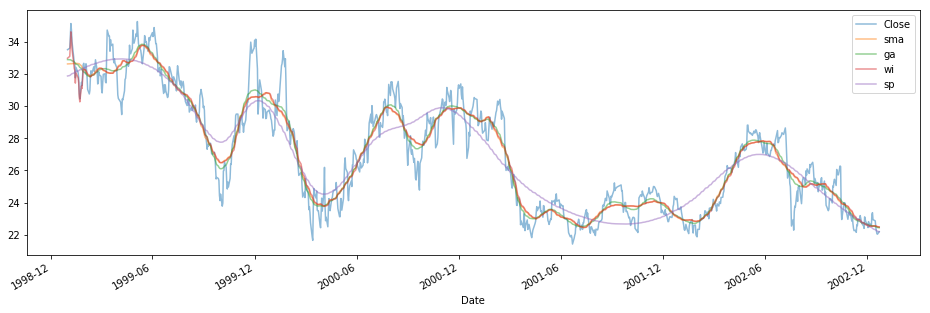

In [136]:
plt.figure(figsize=(16, 6))
results = price[['Close']].assign(sma=filters.convolve1d(price.Close, f_sma),
                                  ga=filters.convolve1d(price.Close, f_ga),
                                  wi = f_wi(price.Close),
                                  sp = f_sp(price.Close))
results[:1000].plot(alpha=0.5);

<Figure size 1152x432 with 0 Axes>

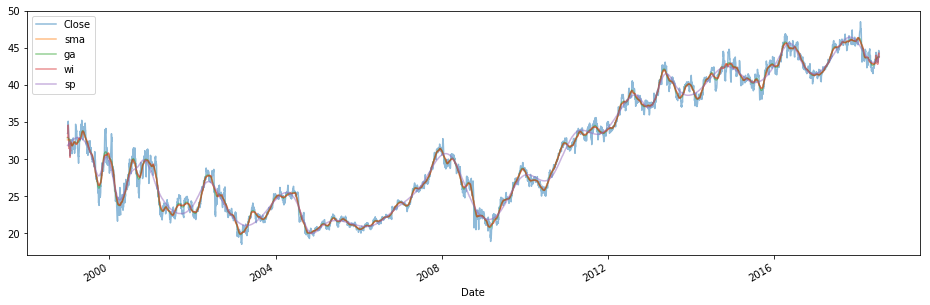

In [138]:
plt.figure(figsize=(16, 6));
results.plot(alpha = 0.5);

## Trends 

### Peaks and Valleys

In [139]:
from scipy.signal import find_peaks

In [148]:
peaks, _ = find_peaks(results.sp)
valleys, _ = find_peaks(-results.sp)

In [172]:
results = results.assign(Trend=np.nan)

In [178]:
results['Trend'][peaks + 1] = -1
results['Trend'][valleys + 1] = 1
results.Trend.fillna(method='ffill', inplace=True)

In [179]:
results

,Close,sma,ga,wi,sp,Trend
Date,,,,,,
1998-12-31,33.500,32.616875,32.885617,32.972485,31.867313,NaN
1999-01-04,33.595,32.618375,32.880146,33.086947,31.896711,NaN
1999-01-05,34.280,32.625375,32.873008,33.772198,31.925808,NaN
1999-01-06,35.125,32.637875,32.863084,34.609025,31.954600,NaN
1999-01-07,34.720,32.626875,32.836589,34.232129,31.983082,NaN
...,...,...,...,...,...,...
2018-07-02,43.750,43.737500,43.778446,43.449942,43.634165,1.0
2018-07-03,43.990,43.749250,43.784459,43.673427,43.675796,1.0
2018-07-05,44.660,43.767250,43.792350,44.318890,43.719044,1.0


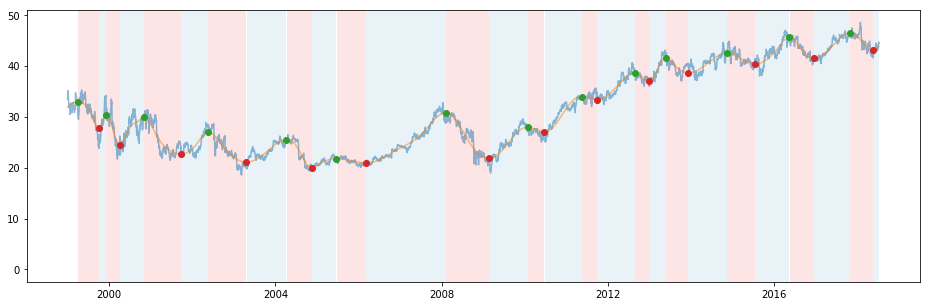

In [187]:
fig, ax = plt.subplots(figsize=(16, 5))
trans = matplotlib.transforms.blended_transform_factory(ax.transData, ax.transAxes)
ax.fill_between(results.index, 0, results.Trend.max(), where= results.Trend > 0, facecolor=pal[0],
                        alpha=0.25, transform=trans, label='Trend up')
ax.fill_between(results.index, 0, results.Trend.max(), where= results.Trend < 0, facecolor=pal[4],
                alpha=0.25, transform=trans, label='Trend down')
plt.plot(results['Close'], alpha = 0.5)
plt.plot(results['sp'], alpha = 0.5)
plt.plot(results.iloc[peaks]['sp'], 'o', label='peaks')
plt.plot(results.iloc[valleys]['sp'], 'o', label='valleys')
plt.show()

### Slopes